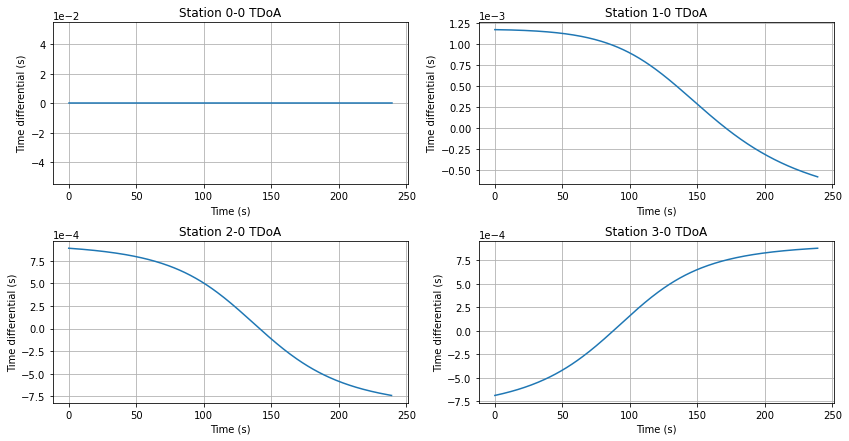

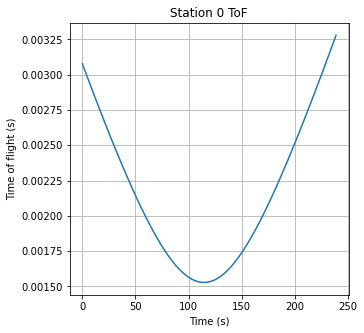

In [43]:
import time
import numpy as np
import argparse
import os

from astropy.time import Time   # Astropy 4.1rc1 is used

from orbdet.utils.utils import *
from orbdet.utils.utils_aux import *
from orbdet.utils.utils_vis import *

from scipy.optimize import fsolve

%matplotlib inline

np.random.seed(100)
np.set_printoptions(precision=4)

n_obs = 4

x_0, t_sec, x_sat_orbdyn_stm, x_obs_multiple, _ = get_example_scenario(id=3, frame='teme')
tdoa, tof = get_tdoa_simulated(x_sat_orbdyn_stm, x_obs_multiple)
r, rr = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple)

fig_1 = plt.figure(figsize=(14,7))

for i in range(n_obs):
    ax = fig_1.add_subplot(2, 2, i+1)
    ax.plot(t_sec, tdoa[i,:])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Time differential (s)')
    ax.grid(':')
    ax.title.set_text(f"Station {i}-0 TDoA")
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

fig_1.subplots_adjust(hspace=0.35)

fig_2 = plt.figure(figsize=(5,5))

ax = fig_2.add_subplot(1, 1, 1)
ax.plot(t_sec, tof[0,:])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time of flight (s)')
ax.grid(':')
ax.title.set_text(f"Station 0 ToF")

In [88]:

x_0, t_sec, x_sat_orbdyn_stm, x_obs_multiple, _ = get_example_scenario(id=3, frame='teme')
tdoa, tof = get_tdoa_simulated(x_sat_orbdyn_stm, x_obs_multiple)
r, rr = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple)

idx = 200
x_sat = np.expand_dims(x_sat_orbdyn_stm[0:3, idx], axis=1)
x_obs = x_obs_multiple[0:3, :, :]

print(x_obs.shape)

x_obs_mean = np.mean(x_obs, axis=2)

print(x_obs_mean.shape)
print(x_obs_mean[0,idx])
print(x_obs_mean[1,idx])
print(x_obs_mean[2,idx])

vars_0  = [x_sat.item(0)+50000, x_sat.item(1)+50000, x_sat.item(2)+50000, 5e-3]
vars_0  = [x_obs_mean[0, idx]*1.01, x_obs_mean[1, idx]*1.01, x_obs_mean[2, idx]*1.01, 5e-3]

vars_gt = [x_sat.item(0), x_sat.item(1), x_sat.item(2), r[0,idx]/C]
data    = (x_obs_multiple[0:3, idx, :], tdoa[:, idx])

a = tdoa_objective_function(vars_0, *data)

result = fsolve(tdoa_objective_function, vars_0, args=data)

print(f"Initial: \t{np.array(vars_0)}")
print(f"Groundtruth: \t{np.array(vars_gt)}, Norm: \t{np.linalg.norm(vars_gt)}")
print(f"Result: \t{result}, Norm: \t{np.linalg.norm(result)}")
print(f"Difference:\t{result - vars_gt}, Norm: \t{np.linalg.norm(result - vars_gt)}")




(3, 240, 4)
(3, 240)
-4968587.037804102
1824404.8768294165
3532424.92293274
Initial: 	[-5.0183e+06  1.8426e+06  3.5677e+06  5.0000e-03]
Groundtruth: 	[-5.5351e+06  1.4709e+06  3.7147e+06  2.5107e-03], Norm: 	6826365.064508345
Result: 	[-5.5351e+06  1.4709e+06  3.7147e+06  2.5107e-03], Norm: 	6826365.064942342
Difference:	[-4.3027e-04 -9.9248e-04  5.4942e-04  3.1134e-12], Norm: 	0.0012132654805239594


(6, 240, 4)


Text(-5523985.250716093, 1467960.466733252, 'Result')

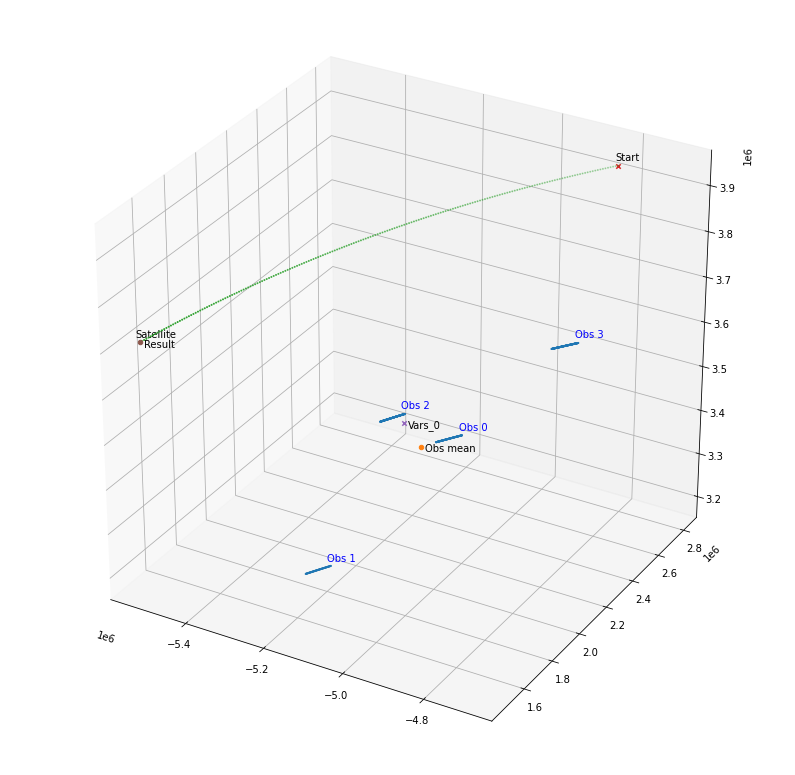

In [93]:
fig = plt.figure(figsize=(14,14))

print(x_obs_multiple.shape)

n_vis = 200
txtp = 1.002
txtn = 0.998

ax = fig.add_subplot(111, projection='3d')

#plot_sphere(ax, d=R_EQ, n=40)
# Observer
obs = ax.scatter(x_obs_multiple[0,:,:], x_obs_multiple[1,:,:], x_obs_multiple[2,:,:], marker='o', s=1)
for i in range(x_obs_multiple.shape[2]):
    ax.text(x_obs_multiple[0,0,i]*txtp, x_obs_multiple[1,0,i]*txtp, x_obs_multiple[2,0,i]*txtp, f"Obs {i}",c='b')
    ax.scatter(x_obs_multiple[0,:,:], x_obs_multiple[1,:,:], x_obs_multiple[2,:,:], marker='o', s=1)
# Mean observer position
obs_mean = ax.scatter(x_obs_mean[0, idx], x_obs_mean[1, idx], x_obs_mean[2, idx], marker='o')
ax.text(x_obs_mean[0, idx]*txtn, x_obs_mean[1, idx]*txtn, x_obs_mean[2, idx]*txtn, f"Obs mean")

# Satellite
sat = ax.scatter(x_sat_orbdyn_stm[0,:n_vis], x_sat_orbdyn_stm[1,:n_vis], x_sat_orbdyn_stm[2,:n_vis], s=1)
sat_0 = ax.scatter(x_sat_orbdyn_stm[0,0], x_sat_orbdyn_stm[1,0], x_sat_orbdyn_stm[2,0], marker='x')
ax.text(x_sat_orbdyn_stm[0,0]*txtp, x_sat_orbdyn_stm[1,0]*txtp, x_sat_orbdyn_stm[2,0]*txtp, "Start")
ax.text(x_sat_orbdyn_stm[0,idx]*txtp, x_sat_orbdyn_stm[1,idx]*txtp, x_sat_orbdyn_stm[2,idx]*txtp, "Satellite")

# Initial position
ax.scatter(vars_0[0], vars_0[1], vars_0[2], marker='x')
ax.text(vars_0[0]*txtn, vars_0[1]*txtn, vars_0[2]*txtn, f"Vars_0")

# Result 
ax.scatter(result[0], result[1], result[2], marker='o', facecolor=None)
ax.text(result[0]*txtn, result[1]*txtn, result[2]*txtn, f"Result")


